# 实例：泰坦尼克号幸存者预测
## 目录：
1. 导入所需要的库
2. 导入数据集，探索数据
3. 对数据集进行预处理
4. 提取标签和特征矩阵，分测试集和训练集
5. 导入模型，粗略跑一下查看结果
6. 在不同的max_depth下观察模型的拟合状况
7. 用网格搜索调整参数
8. 处理测试集数据
9. 进行测试集的预测

为kaggle上的一个比赛，详细内容可以查看  
https://www.kaggle.com/c/titanic  
按照目前的参数，可以达到0.79的正确率，达到了top10%

## 1. 导入所需要的库

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

## 2.导入数据集，探索数据

In [44]:
data = pd.read_csv('titanic/train.csv',index_col=0#把哪一列作为序号
                  )

In [45]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


发现有一些数据存在缺失值，比如Age,Cabin,Embarked

## 3.对数据集进行预处理

### 删除缺失过多的列，以及和判断并没有关系的列

In [47]:
data.drop(['Cabin','Name','Ticket'],inplace=True,axis=1)

### 处理缺失值
对缺失值较多的列进行填补，有一些特征若只有一两个值，可以采取直接删除记录的方法

In [48]:
data["Age"]=data["Age"].fillna(data["Age"].mean())

In [49]:
data = data.dropna()

### 将分类变量转换为数值型变量

In [50]:
data["Sex"] = (data["Sex"] == 'male').astype("int")

### 将三分类变量转换为数值型变量

In [51]:
labels = data["Embarked"].unique().tolist()

In [53]:
data["Embarked"] = data["Embarked"].apply(lambda x:labels.index(x))

In [54]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,0
2,1,1,0,38.0,1,0,71.2833,1
3,1,3,0,26.0,0,0,7.9250,0
4,1,1,0,35.0,1,0,53.1000,0
5,0,3,1,35.0,0,0,8.0500,0


## 4.提取标签和特征矩阵，分测试集和训练集

In [60]:
X = data.iloc[:,data.columns != 'Survived']
y = data.loc[:,'Survived']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

修正测试集和训练集的索引

In [62]:
for i in [X_train,X_test,y_train,y_test]:
    i.index = range(i.shape[0])

## 5.导入模型，粗略跑一下结果

In [64]:
clf = DecisionTreeClassifier(random_state=666)
clf = clf.fit(X_train,y_train)
clf.score(X_test,y_test)

0.7340823970037453

In [66]:
cross_val_score(clf,X,y,cv=10,n_jobs=-1).mean()

0.7773237997957099

## 6.在不同max_depth下观察模型的拟合情况

0.8188968335035749


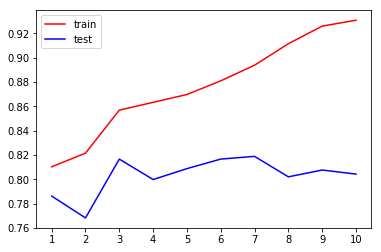

In [68]:
tr = []
te = []
for i in range(10):
    clf = DecisionTreeClassifier(random_state=666,
                                max_depth=i+1,
                                criterion='entropy')
    clf = clf.fit(X_train,y_train)
    score_tr = clf.score(X_train,y_train)
    score_te = cross_val_score(clf,X,y,cv=10).mean()
    tr.append(score_tr)
    te.append(score_te)
    
print(max(te))
plt.plot(range(1,11),tr,color='red',label='train')
plt.plot(range(1,11),te,color='blue',label='test')
plt.xticks(range(1,11))
plt.legend()
plt.show()

## 网格搜索调整参数

In [113]:
param = {
    'splitter':('best','random'),
    'criterion':('gini','entropy'),
    'max_depth':[*range(1,10)],
    'min_samples_leaf':[*range(1,50,5)],
    "max_leaf_nodes":[*range(2,200,20)],
    "min_impurity_decrease":[*np.linspace(0,0.5,20)]
}

In [114]:
clf = DecisionTreeClassifier(random_state=666)
GS = GridSearchCV(
    clf,
    param,
    n_jobs=-1,
    verbose=5,
    cv=10
)
GS.fit(X_train,y_train)

Fitting 10 folds for each of 72000 candidates, totalling 720000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 4376 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 8912 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 14744 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 21872 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 30296 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 40016 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done 51032 tasks      | elapsed:   59.0s
[Parallel(n_jobs=-1)]: Done 63344 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 76952 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 91856 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 108056 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 125552 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 144

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=666,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'splitter': ('best', 'random'), 'criterion': ('gini', 'entropy'), 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'min_samples_leaf': [1, 6, 11, 16, 21, 26, 31, 36, 41, 46], 'max_leaf_nodes': [2, 22, 42, 62, 82, 102, 122, 142, 162, 182], 'min_impurity_decrease': [0.0, 0.02631578947368421, 0.05...0526315789, 0.39473684210526316, 0.42105263157894735, 0.4473684210526315, 0.47368421052631576, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=5)

In [115]:
GS.best_score_

0.8520900321543409

In [116]:
GS.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'max_leaf_nodes': 22,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'splitter': 'random'}

In [117]:
clf = GS.best_estimator_

In [118]:
clf.score(X_test,y_test)

0.7827715355805244

In [119]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
1,3,1,22.0,1,0,7.2500,0
2,1,0,38.0,1,0,71.2833,1
3,3,0,26.0,0,0,7.9250,0
4,1,0,35.0,1,0,53.1000,0
5,3,1,35.0,0,0,8.0500,0


## 8.处理测试集数据

In [121]:
TEST = pd.read_csv('titanic/test.csv',index_col=0)

In [122]:
TEST.drop(['Name','Cabin','Ticket'],inplace=True,axis=1)

In [133]:
TEST.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 7 columns):
Pclass      418 non-null int64
Sex         418 non-null int64
Age         418 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Fare        418 non-null float64
Embarked    418 non-null int64
dtypes: float64(2), int64(5)
memory usage: 26.1 KB


In [127]:
TEST['Age']=TEST['Age'].fillna(data["Age"].mean())
TEST['Fare'] = TEST['Fare'].fillna(data['Fare'].mean())

In [130]:
TEST["Sex"] = (TEST["Sex"] == 'male').astype("int")

In [132]:
TEST['Embarked'] = TEST['Embarked'].apply(lambda x:labels.index(x))

## 9. 进行测试集的预测

In [135]:
now =  clf.predict(TEST)

In [148]:
test = pd.concat([pd.DataFrame(TEST.index),pd.DataFrame(now,columns=['Survived'])],axis=1)

In [152]:
test.to_csv('predict2.csv',index=False)